In [61]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [113]:
def get_updated_values_MC(values, greedy_policy, gamma, n_samples=50) :
    updated_values = np.zeros_like(values)
    for num_cars_loc1 in range(21) :
        for num_cars_loc2 in range(21) :
            prev_value = values       [num_cars_loc1, num_cars_loc2]
            move_cars  = greedy_policy[num_cars_loc1, num_cars_loc2]
            act_num_cars_loc1 = num_cars_loc1 - move_cars
            act_num_cars_loc2 = num_cars_loc2 + move_cars
            num_returns_loc1  = np.random.poisson(size=(n_samples,), lam=3)
            num_requests_loc1 = np.random.poisson(size=(n_samples,), lam=3)
            num_returns_loc2  = np.random.poisson(size=(n_samples,), lam=2)
            num_requests_loc2 = np.random.poisson(size=(n_samples,), lam=4)
            exp_return = 0.
            for ret1, req1, ret2, req2 in zip(num_returns_loc1, num_requests_loc1, num_returns_loc2, num_requests_loc2) :
                tmp_num_cars_loc1 = np.min([act_num_cars_loc1 + ret1, 20])
                act_requests_loc1 = np.min([req1, tmp_num_cars_loc1])
                tmp_num_cars_loc2 = np.min([act_num_cars_loc2 + ret2, 20])
                act_requests_loc2 = np.min([req2, tmp_num_cars_loc2])
                exp_return += 10 * (act_requests_loc1 + act_requests_loc2) / n_samples
            exp_return += -2*np.fabs(move_cars)
            updated_values[num_cars_loc1, num_cars_loc2] = exp_return + gamma * prev_value
    return updated_values
        

In [114]:
def get_updated_values_exact(values, greedy_policy, gamma, max_poisson=10) :
    updated_values = np.zeros_like(values)
    for num_cars_loc1 in range(21) :
        for num_cars_loc2 in range(21) :
            move_cars         = greedy_policy[num_cars_loc1, num_cars_loc2]
            act_num_cars_loc1 = int(num_cars_loc1 - move_cars)
            act_num_cars_loc2 = int(num_cars_loc2 + move_cars)
            next_value        = values       [act_num_cars_loc1, act_num_cars_loc2]
            exp_value        = -2*np.fabs(move_cars) + gamma * next_value
            for num_returns_loc1 in range(1+max_poisson) :
                return_prob = stats.poisson.pmf(num_returns_loc1, mu=3)
                tmp_num_cars_loc1 = np.min([act_num_cars_loc1 + num_returns_loc1, 20])
                for num_requests_loc1 in range(1+max_poisson) :
                    request_prob      = stats.poisson.pmf(num_requests_loc1, mu=3)
                    act_requests_loc1 = np.min([num_requests_loc1, tmp_num_cars_loc1])
                    exp_value += return_prob * request_prob * 10 * act_requests_loc1
            for num_returns_loc2 in range(1+max_poisson) :
                return_prob = stats.poisson.pmf(num_returns_loc2, mu=2)
                tmp_num_cars_loc2 = np.min([act_num_cars_loc2 + num_returns_loc2, 20])
                for num_requests_loc2 in range(1+max_poisson) :
                    request_prob      = stats.poisson.pmf(num_requests_loc2, mu=4)
                    act_requests_loc2 = np.min([num_requests_loc2, tmp_num_cars_loc2])
                    exp_value += return_prob * request_prob * 10 * act_requests_loc2
            updated_values[num_cars_loc1, num_cars_loc2] = exp_value
    return updated_values
        

In [115]:
def get_greedy_policy(values) :
    policy = np.zeros_like(values)
    for num_cars_loc1 in range(21) :
        for num_cars_loc2 in range(21) :
            this_value = values[num_cars_loc1, num_cars_loc2]
            move_cars, best_dv = 0, 0.
            for tmp_move_cars in np.linspace(-5, 5, 11) :
                tmp_move_cars = int(tmp_move_cars)
                new_num_cars_loc1, new_num_cars_loc2 = num_cars_loc1-tmp_move_cars, num_cars_loc2+tmp_move_cars
                if new_num_cars_loc1 < 0  : continue
                if new_num_cars_loc1 > 20 : continue
                if new_num_cars_loc2 < 0  : continue
                if new_num_cars_loc2 > 20 : continue
                other_value = values[new_num_cars_loc1, new_num_cars_loc2]
                delta_value = other_value - this_value
                if delta_value < best_dv : continue
                move_cars, best_dv = tmp_move_cars, delta_value
            policy[num_cars_loc1, num_cars_loc2] = move_cars 
    return policy
        

In [127]:
def plot_policy_and_values(policy, values) :
    fig = plt.figure(figsize=(13, 4))
    
    ax  = fig.add_subplot(1, 2, 1)
    cb = ax.matshow(np.flip(policy, axis=0), vmin=-5, vmax=5, cmap="bwr")
    ax.tick_params(axis="both", direction="in", top=True, right=True)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_ticks([0, 5, 10, 15, 20])
    ax.yaxis.set_ticklabels(["20", "15", "10", "5", "0"])
    ax.set_xlabel("Num. cars (loc2)", labelpad=20)
    ax.set_ylabel("Num. cars (loc1)", labelpad=20)
    cbar = plt.colorbar(cb)
    cbar.set_label("Num. cars\n"+r"(loc1 $\rightarrow$ loc2)", labelpad=50, rotation=0)
    
    ax  = fig.add_subplot(1, 2, 2)
    cb = ax.matshow(np.flip(values, axis=0), cmap="bwr")
    ax.tick_params(axis="both", direction="in", top=True, right=True)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_ticks([0, 5, 10, 15, 20])
    ax.yaxis.set_ticklabels(["20", "15", "10", "5", "0"])
    ax.set_xlabel("Num. cars (loc2)", labelpad=20)
    ax.set_ylabel("Num. cars (loc1)", labelpad=20)
    cbar = plt.colorbar(cb)
    cbar.set_label("Expected\nvalue", labelpad=45, rotation=0)
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    

Value estimation with delta = 9.61 ***********
Policy iteration 1 complete:


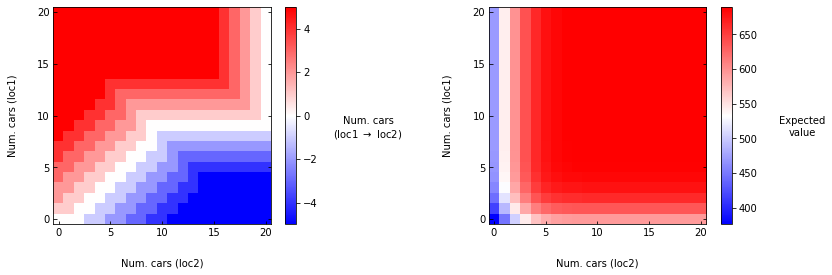

Value estimation with delta = 9417.22 ********

KeyboardInterrupt: 

In [130]:
use_MC          = False
n_samples       = 100
max_poisson     = 9
delta_tolerance = 10
gamma           = 0.9

policy = np.zeros(shape=(21, 21))
for itr_idx in range(2) :
    delta  = np.inf
    values = np.zeros(shape=(21, 21))
    while delta > delta_tolerance :
        if use_MC : new_values = get_updated_values_MC   (values, policy, gamma, n_samples=n_samples)
        else      : new_values = get_updated_values_exact(values, policy, gamma, max_poisson=max_poisson)
        delta = np.sum(np.fabs(new_values-values))
        sys.stdout.write(f"\rValue estimation with delta = {delta:.2f} *******")
        sys.stdout.flush()
        values = new_values
    sys.stdout.write("\n")
    sys.stdout.flush()
    policy = get_greedy_policy(values)
    print(f"Policy iteration {1+itr_idx} complete:")
    plot_policy_and_values(policy, values)
    

Value iteration 1 complete:


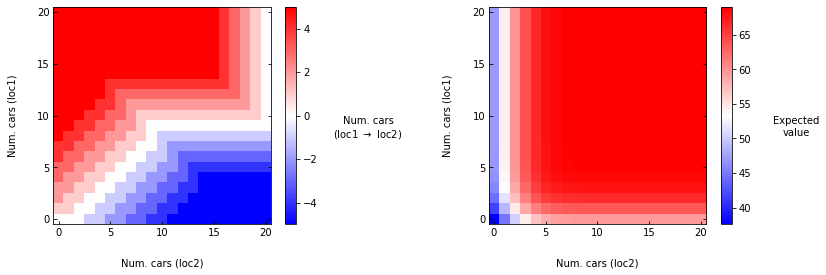

Value iteration 2 complete:


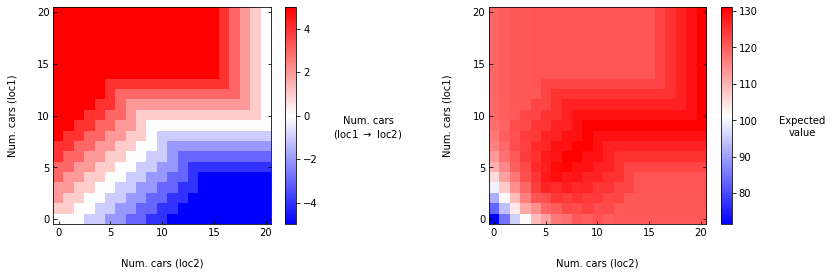

Value iteration 3 complete:


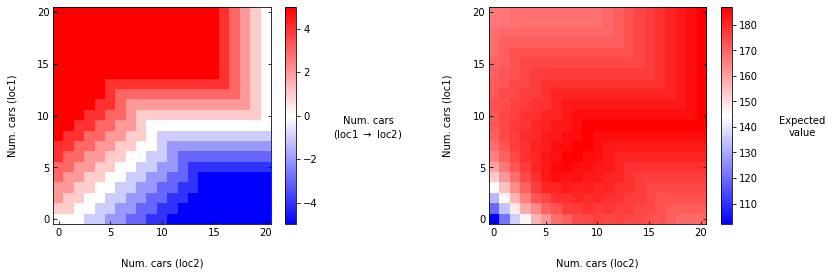

Value iteration 4 complete:


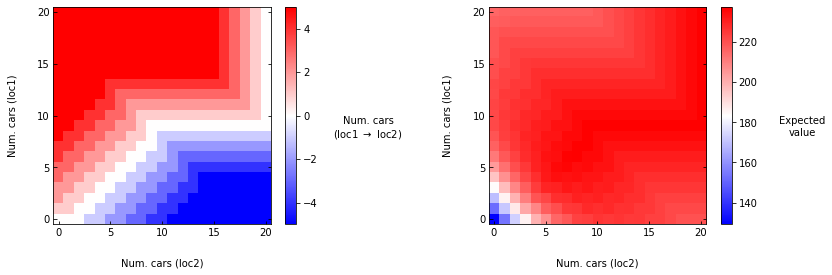

Value iteration 5 complete:


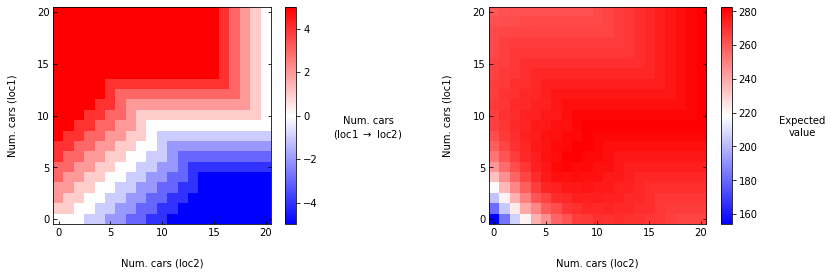

Value iteration 6 complete:


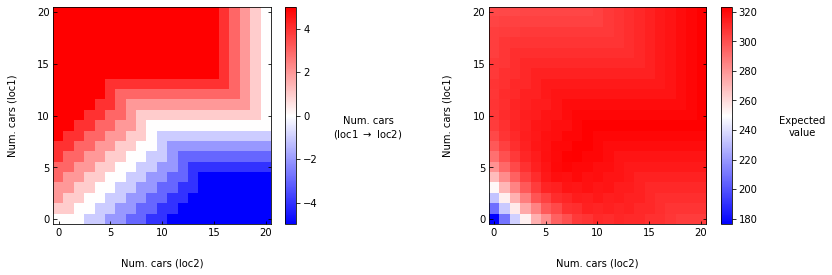

Value iteration 7 complete:


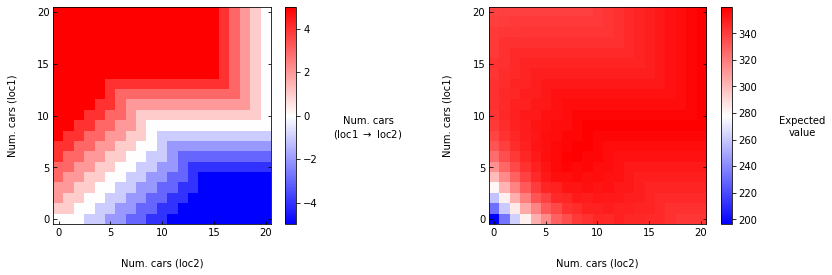

Value iteration 8 complete:


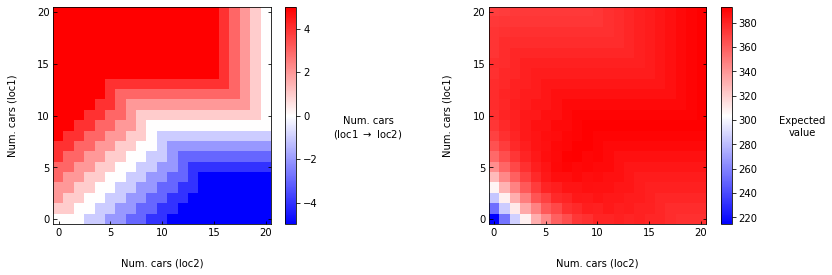

Value iteration 9 complete:


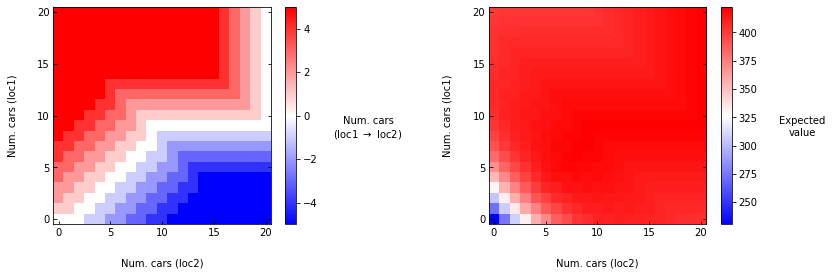

KeyboardInterrupt: 

In [132]:
use_MC          = False
n_samples       = 100
max_poisson     = 9
delta_tolerance = 10
gamma           = 0.9

policy = np.zeros(shape=(21, 21))
values = np.zeros(shape=(21, 21))
for itr_idx in range(10) :
    if use_MC : values = get_updated_values_MC   (values, policy, gamma, n_samples=n_samples)
    else      : values = get_updated_values_exact(values, policy, gamma, max_poisson=max_poisson)
    policy = get_greedy_policy(values)
    print(f"Value iteration {1+itr_idx} complete:")
    plot_policy_and_values(policy, values)
    